# 프로젝트 : CIFAR-10 이미지 생성하기를 가장한 Crypto Punks 이미지 생성하기
- GAN을 학습하는 과정은 생각보다 어려웠다. 
- 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자 간의 versus, 데이터의 특성 등 고려해야 할 것이 참 많았다.

- 이번에는 익스에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 따라가지 않고, 
- 나만의 "CRYPTO PUNK" 이미지를 생성해 보는 프로젝트를 진행하도록 하겠다.

---
- Crypto Punks : 이더리움 블록체인의 대체 불가능한 토큰 모음. (아래 이미지와 같은 픽셀 형태의 캐릭터)

![cp](https://s32659.pcdn.co/wp-content/uploads/2021/09/CryptoPunks-list.jpg.optimal.jpg)

## 목차
[STEP 0. 작업환경 구성하기](#STEP-0.-작업환경-구성하기)  
[STEP 1. 데이터셋 구성하기](#STEP-1.-데이터셋-구성하기)  
[STEP 2. 생성자 모델 구현하기](#STEP-2.-생성자-모델-구현하기)  
[STEP 3. 판별자 모델 구현하기](#STEP-3.-판별자-모델-구현하기)  
[STEP 4. 손실함수와 최적화 함수 구현하기](#STEP-4.-손실함수와-최적화-함수-구현하기)  
[STEP 5. 훈련과정 상세 기능 구현하기](#STEP-5.-훈련과정-상세-기능-구현하기)  
[STEP 6. 학습 과정 진행하기](#STEP-6.-학습-과정-진행하기)  
[Rubric](#Rubric)  
[회고](#회고)

## STEP 0. 작업환경 구성하기
---
다음과 같이 작업환경을 구성.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## STEP 1. 데이터셋 구성하기
---
- CryptoPunks 이미지셋은 Kaggle(https://www.kaggle.com/tunguz/cryptopunks) 에서 구함. 47MB (1만장)
- 다음과 같이 경로 설정.
- .jsonl 파일은 캐릭터의 각종 데이터 정보가 담겨져 있음. 

In [2]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
base_dir = ROOT_PATH + '/crypto_punk/input/'
os.listdir(base_dir)

['imgs', 'archive.zip', 'txn_history-2021-10-07.jsonl']

In [3]:
data_dir = '../crypto_punk/input/txn_history-2021-10-07.jsonl'
image_dir = "../crypto_punk/input/imgs/imgs"
image_root = "../crypto_punk/input/imgs"

In [4]:
df = pd.read_json(base_dir + 'txn_history-2021-10-07.jsonl', lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


- 1만장 중 100개의 샘플 확인용 print. (아래 코드.)

Sample 100 CryptoPunks


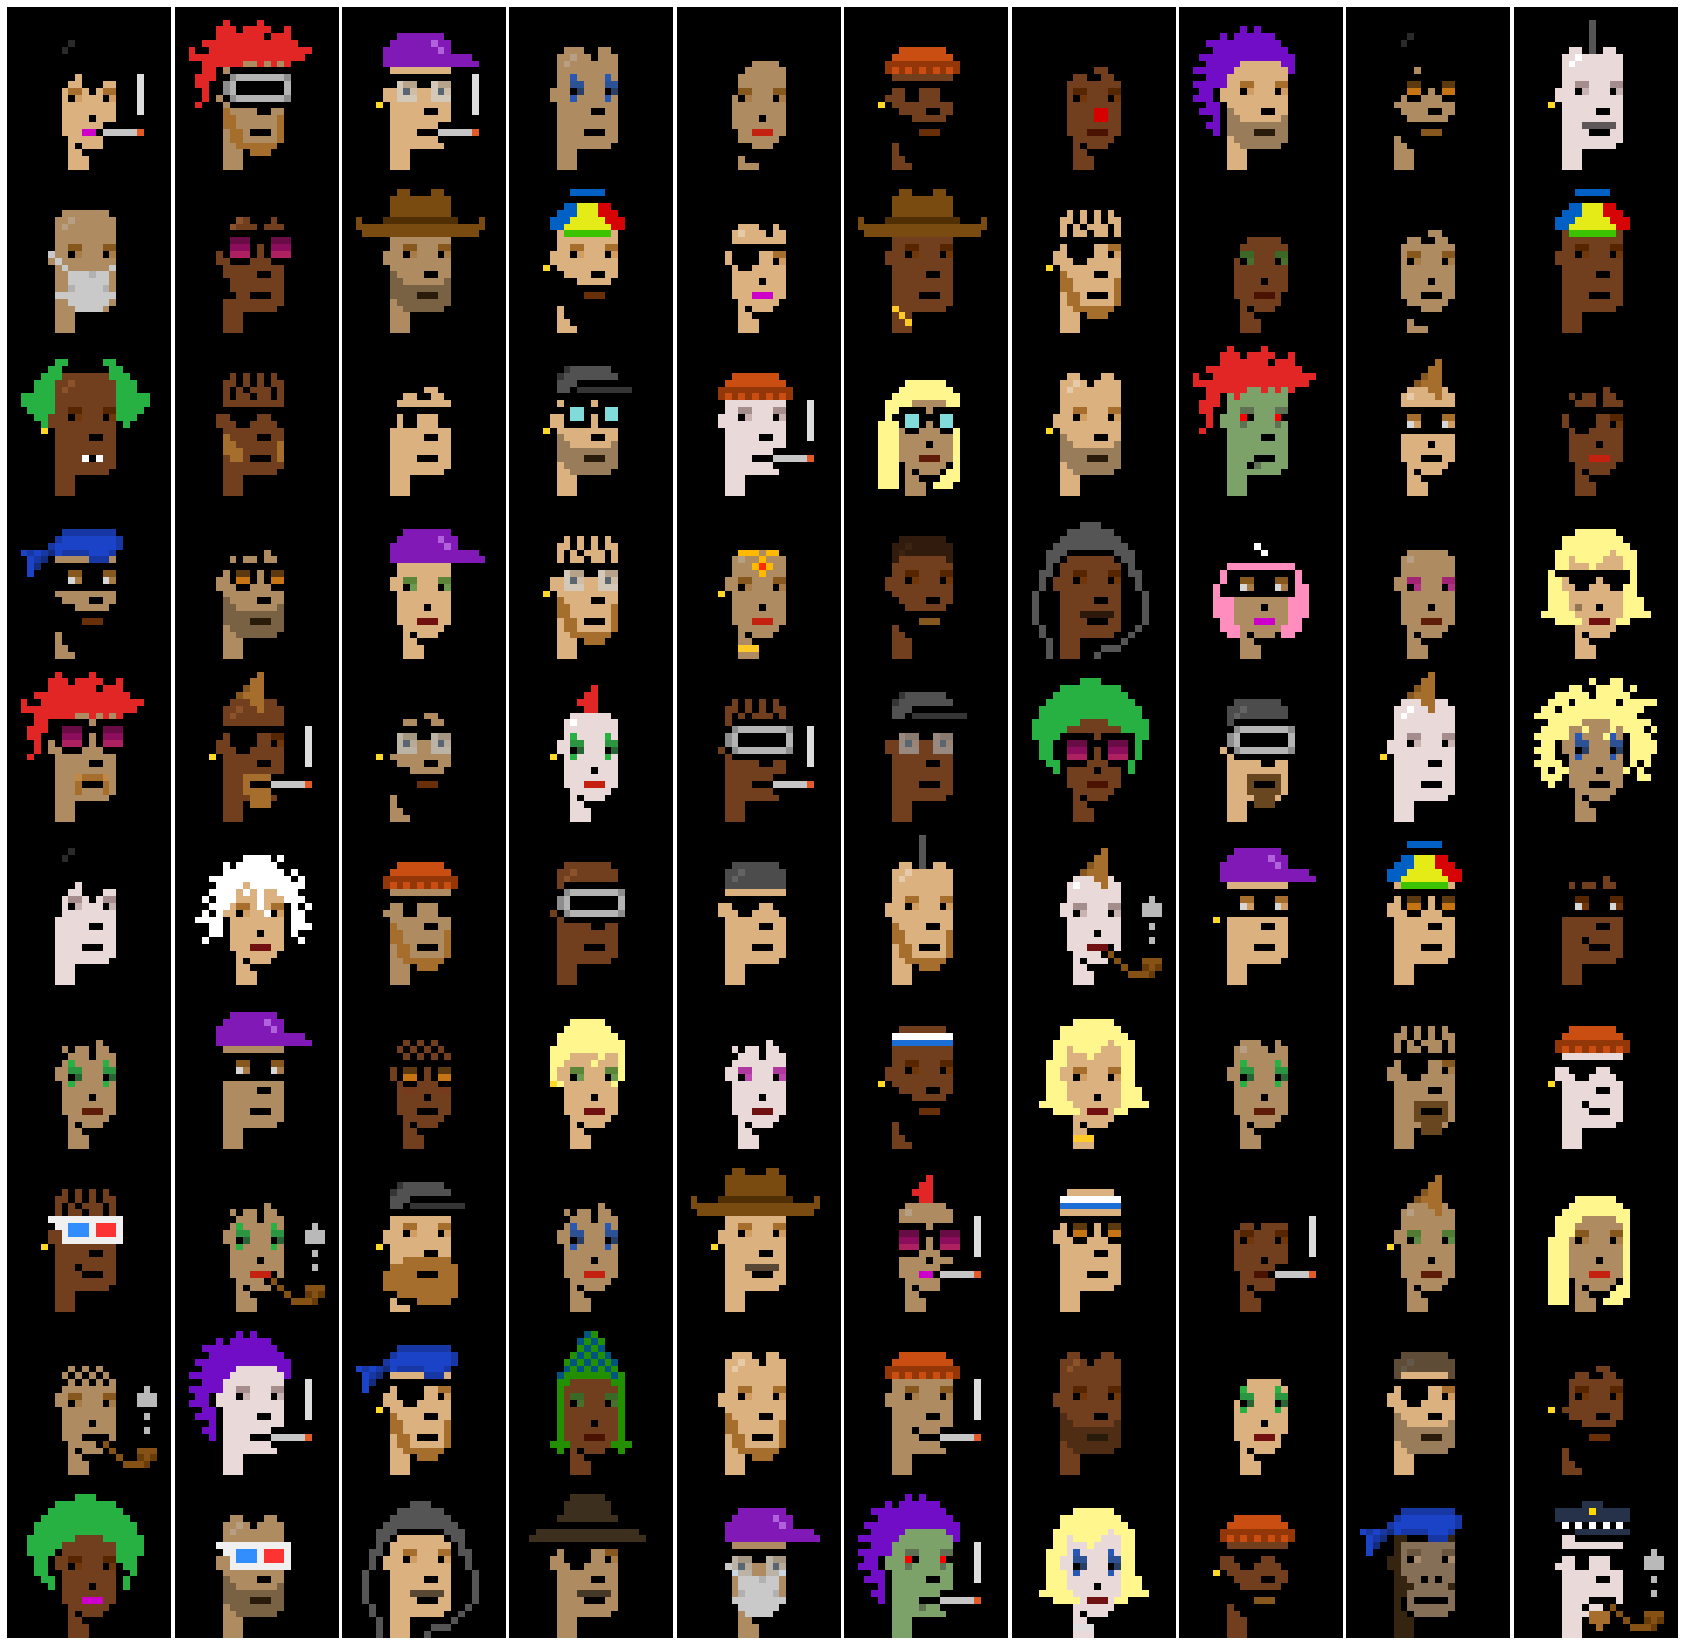

In [5]:
no_plots = 10*10

images = glob.glob("../crypto_punk/input/imgs/imgs/*.png")

plt.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample 100 CryptoPunks")
for idx, image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    plt.subplot(10, 10, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)) #covert color space
plt.show()

In [6]:
punks = [img for img in glob.glob("../crypto_punk/input/*.png")]

for punk in punks[0:3]:
    img = plt.imread(punk)
    plt.imshow(img)
    plt.show()

In [7]:
df = df[["txn_type", "date", "eth", "punk_id", "type", "accessories"]]
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [8]:
#이미지 표시
def tensor_imshow(img, dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg * 0.5 + 0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
def get_dataloader(batch_size,         
                   image_size,    
                   data_dir=image_dir,   
                   num_workers=3):
    
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
    
    #이미지 사이즈 변환
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),  
                                    transforms.ToTensor(),                        
                                    transforms.Normalize(*stats)])                
    
    #데이터 셋 생성
    dataset = datasets.ImageFolder(root=data_dir,
                                   transform=transform)
    
    
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
    
    return data_loader

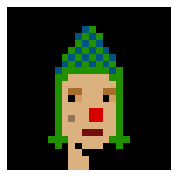

In [10]:
#데이터 셋 샘플 출력
batch_size, image_size = 5, 24

train_loader = get_dataloader(batch_size,
                              image_size,
                              image_root)

dataiter = iter(train_loader)

img,_ = next(dataiter)
sample_img = img[-1]

tensor_imshow(sample_img)

## STEP 2. 생성자 모델 구현하기
---
- class를 사용하여 구현

In [11]:
class Generator(nn.Module):
    def __init__(self, 
                 z_dim=100,     
                 im_chan=3,      
                 hidden_dim=64): 
        
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        
        self.generator_cnn = nn.Sequential(self.make_gen_block(z_dim, hidden_dim*8, stride=1, padding=0),   
                                           #(64*8) x 4 x 4
                                           self.make_gen_block(hidden_dim*8, hidden_dim*4),                           
                                           #(64*4) x 8 x 8
                                           self.make_gen_block(hidden_dim*4, hidden_dim*2),                           
                                           #(64*2) x 16 x 16
                                           self.make_gen_block(hidden_dim*2, hidden_dim),                             
                                           #(64) x 32 x 32
                                           self.make_gen_block(hidden_dim, im_chan, final_layer=True))
    
    def make_gen_block(self, 
                       im_chan,    
                       op_chan,     
                       kernel_size=4, 
                       stride=2, 
                       padding=1, 
                       final_layer=False): 
        
        layers = []
        layers.append(nn.ConvTranspose2d(im_chan,     
                                         op_chan, 
                                         kernel_size, 
                                         stride, 
                                         padding, 
                                         bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator_cnn(x)

    def get_noise(n_samples, 
                  z_dim, 
                  device='cpu'):
        return torch.randn(n_samples, 
                           z_dim, 
                           device=device)

In [12]:
noise = Generator.get_noise(n_samples=5,
                            z_dim=100)

g = Generator(z_dim=100,
              im_chan=3,
              hidden_dim=64)
print(g)

Generator(
  (generator_cnn): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## STEP 3. 판별자 모델 구현하기
---
- 3 채널 RGB의 64사이즈.

In [13]:
class Discriminator(nn.Module):
    def __init__(self, 
                 im_chan=3,       # RGB 3 chan
                 conv_dim=64,     # convnet dimension
                 image_size=64):  # size
        
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(self.make_disc_block(im_chan, conv_dim),
                                      self.make_disc_block(conv_dim, conv_dim*2),
                                      self.make_disc_block(conv_dim*2, conv_dim*4),
                                      self.make_disc_block(conv_dim*4, conv_dim*8),
                                      self.make_disc_block(conv_dim*8, 1, padding=0, final_layer=True)) 
    def make_disc_block(self,
                        im_chan,
                        op_chan,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        final_layer=False):
        layers = []
        layers.append(nn.Conv2d(im_chan,
                                op_chan,
                                kernel_size,
                                stride,
                                padding,
                                bias=False))

        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)

    # 1차원 TF 반환을 위한 함수
    
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [14]:
d = Discriminator(im_chan=3,
                  conv_dim=64,
                  image_size=64)
print(d)

Discriminator(
  (disc_cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

## STEP 4. 손실함수와 최적화 함수 구현하기
---
- 생성자와 판별자의 손실함수(loss)를 구현.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현.

In [15]:
# 모델 매개변수 설정

def weights_init_normal(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weights, 0.0, 0.02)
    
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weights, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [16]:
# 손실함수 구현

def real_loss(D_out,device='cpu'): 
                                                             
   
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size, device=device)*0.9
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out, device='cpu'):

    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size,
                         device=device) 
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [17]:
#모델 

def print_tensor_images(images_tensor):
    
        
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()

## STEP 5. 훈련과정 상세 기능 구현하기
---
- Part 1. 판단자 훈련
- Part 2. 생성자 훈련

In [18]:
def train(D, G, 
          n_epochs,
          dataloader,
          d_optimizer,
          g_optimizer,
          z_dim,
          print_every=50,
          device='cpu'):
    
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,
                                  z_dim=z_dim,
                                  device=device)
    
    for epoch in range(1,n_epochs+1):
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            
            # PART 1. 판단자 Train.
            d_optimizer.zero_grad()
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,
                                    device=device)
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op,
                                    device=device)
            d_loss = d_real_loss + d_fake_loss

 

            d_loss.backward()
            d_optimizer.step()
            
            
            # PART 2. Generator Train.
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out, 
                               device=device) 
            g_loss.backward()
            g_optimizer.step()
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch, 
                                                                               n_epochs, 
                                                                               d_loss.item(), 
                                                                               g_loss.item()))
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()

## STEP 6. 학습 과정 진행하기
---
- 위 STEP 5에서 구현한 기능들을 활용하여 모델 학습을 진행.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현.
- 학습 과정을 담은 샘플 이미지, gif 파일 생성.

In [19]:
# 하이퍼 파라미터 설정

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ", device)

z_dim = 100
beta_1 = 0.5 
beta_2 = 0.999 
lr = 0.0002
n_epochs = 100
batch_size = 128
image_size = 64

Device is  cuda


In [20]:
# 생성자 초기화
generator = Generator(z_dim, 
                      im_chan=3, 
                      hidden_dim=64).to(device)

# 판단자 초기화
discriminator = Discriminator(im_chan=3, 
                              conv_dim=64, 
                              image_size=image_size).to(device)

# 생성자에 대한 Adam 최적화
g_optimizer = optim.Adam(generator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

# 판단자에 대한 Adam 최적화
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

dataloader = get_dataloader(batch_size, 
                            image_size, 
                            image_root)

- 훈련 시작 (아래 코드)

In [21]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 8, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/crypto_punk/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [22]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/crypto_punk/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [23]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/crypto_punk/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 11.2 µs
Epoch [    1/   10] | d_loss: 0.3381 | g_loss: 5.6012
Epoch [    2/   10] | d_loss: 0.6316 | g_loss: 3.1837


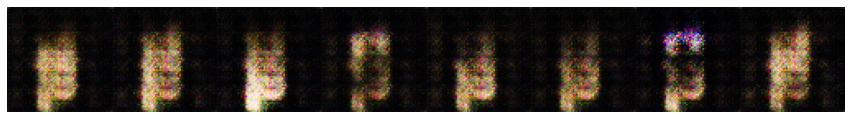

Epoch [    3/   10] | d_loss: 0.4595 | g_loss: 2.0186
Epoch [    4/   10] | d_loss: 0.4787 | g_loss: 2.0519


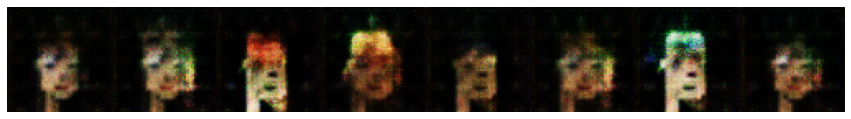

Epoch [    5/   10] | d_loss: 0.4460 | g_loss: 1.6024
Epoch [    6/   10] | d_loss: 1.1157 | g_loss: 1.6495


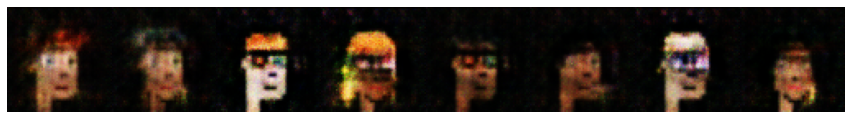

Epoch [    7/   10] | d_loss: 0.4939 | g_loss: 2.6018
Epoch [    8/   10] | d_loss: 0.4625 | g_loss: 2.5357


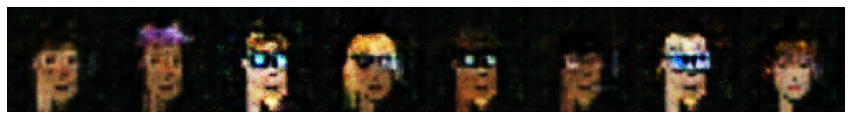

Epoch [    9/   10] | d_loss: 0.4446 | g_loss: 1.4178
Epoch [   10/   10] | d_loss: 0.3959 | g_loss: 3.1602


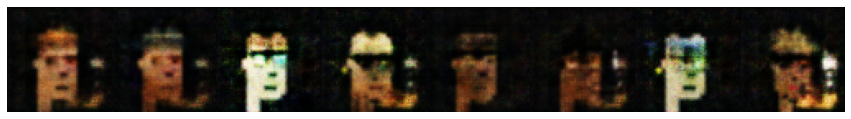

In [24]:
%time
n_epochs = 10
train(discriminator,
      generator,
      n_epochs,
      dataloader,
      d_optimizer,
      g_optimizer,
      z_dim,
      print_every=2,
      device=device)

In [25]:
def save_model(generator,file_name):
    generator = generator.to('cuda')
    torch.save(generator.state_dict(),"cryptopunks_generator.pth")

save_model(generator,"kaggle")

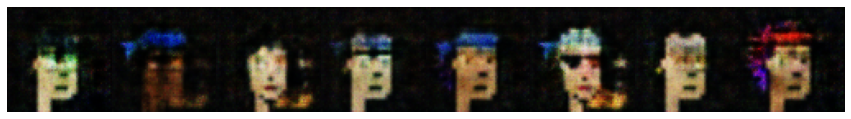

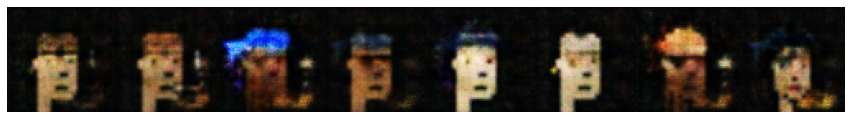

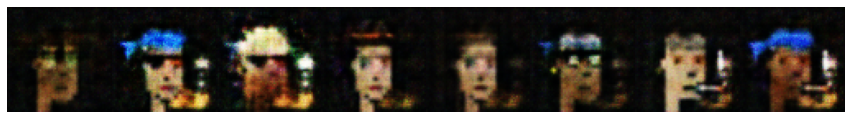

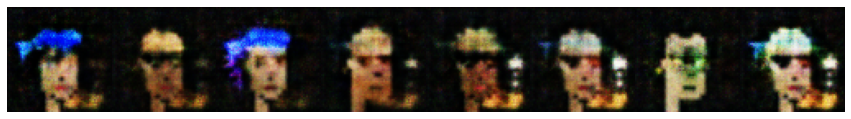

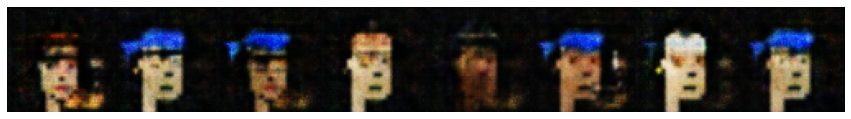

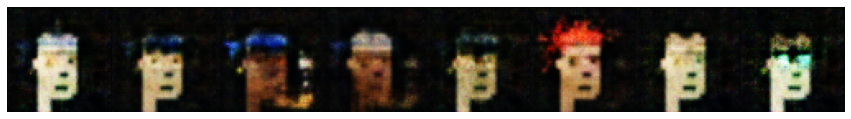

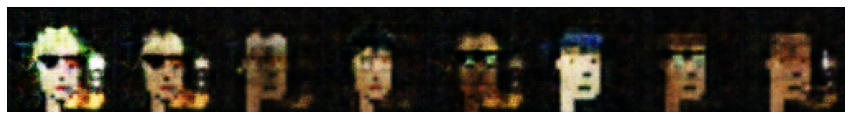

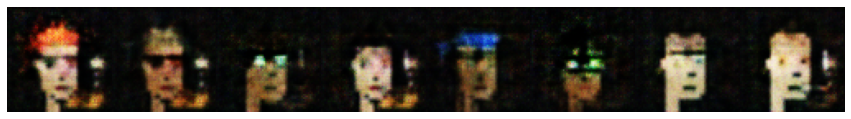

In [26]:
generator.to(device)
generator.eval() 
sample_size=8

for i in range(8):    
    
    fixed_z = Generator.get_noise(n_samples=sample_size, 
                                  z_dim=z_dim, 
                                  device=device)    
    
    sample_image = generator(fixed_z)
    print_tensor_images(sample_image)

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|Crypto Punk 이미지를 육안으로 구별할 수 있을 정도로 생성하였다.|
|**2**|생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.| "print_every=2" 를 통해 생성이미지 품질이 서서히 향상되는 것을 확인하였다.|
|**3**|추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|익스 기본 예제를 통해 새로운 패션 이미지를 생성하였다.|

## 회고
- 흥미롭게 알고만 있던 GAN 프로젝트를 진행해 보았다. 최근 "Style GAN 3"_(https://github.com/NVlabs/stylegan3) 또한 출시되어 매우 관심이 있던 NFT 관련 Crypto Punk 이미지를 생성하는데 성공했다.
- 진행하면서, 각 epoch 마다 .png 파일을 생성하기위해 부단한 노력을 했지만, 경로설정문제인지 잘 되지 않아, 2 epoch 마다 현 train 상황을 시각적으로 볼 수 있게 print 문을 사용하여 대체 해 보았다.

### 알게된 점
- GAN 이라는 대략적으로 알고있던 주제를 직접 몸으로 부딛혀보며 깨우쳐보니 막상 준비해야 될 것이 너무 많았다. 
- 생성자, 판단자 개념에 대해 좀더 깊게 공부하고싶어서 유투브, 블로그 등을 많이 찾아보았고 많은 도움이 되었다.

### 느낀 점
- 모델이 생성자와 판단자로 서로 개선을 시키는 방향으로 모델을 개선시키는 구동 원리가 매우 재미있었다.
- 모델을 train하는 데 걸리는 시간이 너무 오래 걸려 다양한 하이퍼 파라미터를 바꿔가며 테스팅 하지 못해 아쉬웠다.